In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.linear_model import Ridge 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# ML model interpretation libraries
from lime import lime_tabular
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from warnings import filterwarnings
filterwarnings('ignore')

# reading the data in the form of pandas dataframe object
data = pd.read_excel("data.xlsx")
df = data.copy()
df.head()

,Paper No,Specimen,tw,lw,hw,M/Vlw,P/Agfc,fc,Ab,Ag,Ab/Ag,ρbl.fybl,ρsh.fysh,ρl.fyl,ρt.fyt,v_test,failure_mode
0,Abdulridha & Palermo (2017),W1-SR,150.0,1000,2200.0,2.20,0.00,30.5,30000.0,150000.0,0.200000,5.652500,7.395000,2.847500,3.740000,155.15,3.0
1,[114] Adajar et al.1995,RCW1,150.0,1400,2000.0,1.43,0.01,46.8,0.0,210000.0,0.000000,0.000000,0.000000,4.410368,2.021229,666.82,3.0
2,NaN,RCW3,150.0,1400,2000.0,1.43,0.01,46.6,0.0,210000.0,0.000000,0.000000,0.000000,7.725619,2.021229,787.40,1.0
3,"[98] Adebar,2007",High-Rise Core Wall (265),127.0,1625,12000.0,7.38,0.10,49.0,77140.0,309093.0,0.249569,2.956163,2.667677,1.219476,1.177428,144.75,3.0
4,"[26] Alarcon,2014",W1 (49),100.0,700,1600.0,2.50,0.15,27.4,10000.0,70000.0,0.142857,14.732880,0.000000,2.673600,2.655481,143.15,2.0


In [4]:
df.drop(["Paper No", "Specimen"], axis=1, inplace=True)
df.head()

,tw,lw,hw,M/Vlw,P/Agfc,fc,Ab,Ag,Ab/Ag,ρbl.fybl,ρsh.fysh,ρl.fyl,ρt.fyt,v_test,failure_mode
0,150.0,1000,2200.0,2.20,0.00,30.5,30000.0,150000.0,0.200000,5.652500,7.395000,2.847500,3.740000,155.15,3.0
1,150.0,1400,2000.0,1.43,0.01,46.8,0.0,210000.0,0.000000,0.000000,0.000000,4.410368,2.021229,666.82,3.0
2,150.0,1400,2000.0,1.43,0.01,46.6,0.0,210000.0,0.000000,0.000000,0.000000,7.725619,2.021229,787.40,1.0
3,127.0,1625,12000.0,7.38,0.10,49.0,77140.0,309093.0,0.249569,2.956163,2.667677,1.219476,1.177428,144.75,3.0
4,100.0,700,1600.0,2.50,0.15,27.4,10000.0,70000.0,0.142857,14.732880,0.000000,2.673600,2.655481,143.15,2.0


In [5]:
print(df.shape)
print(df.isnull().sum())

(497, 15)
tw               0
lw               0
hw               0
M/Vlw            0
P/Agfc           0
fc               0
Ab               0
Ag               0
Ab/Ag            0
ρbl.fybl         4
ρsh.fysh        20
ρl.fyl           0
ρt.fyt           0
v_test          24
failure_mode     6
dtype: int64


In [6]:
df.dropna(inplace=True, axis=0)
df.shape

(470, 15)

In [7]:
X = df.drop(['v_test'], axis=1)
y = df["v_test"]

In [8]:
# Scaled data is used for Ridge Linear Regression, SVM and MLP models
cols = X.columns
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=cols)

# Performances of ML Models

In [9]:
# list of random numbers used to split the data into train and test 100 times
randomlist = random.sample(range(1, 10000), 100)

## LightGBM

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'max_depth': 6, 'min_child_samples': 8, 'n_estimators': 200, 'num_leaves': 10, 'subsample': 0.1}


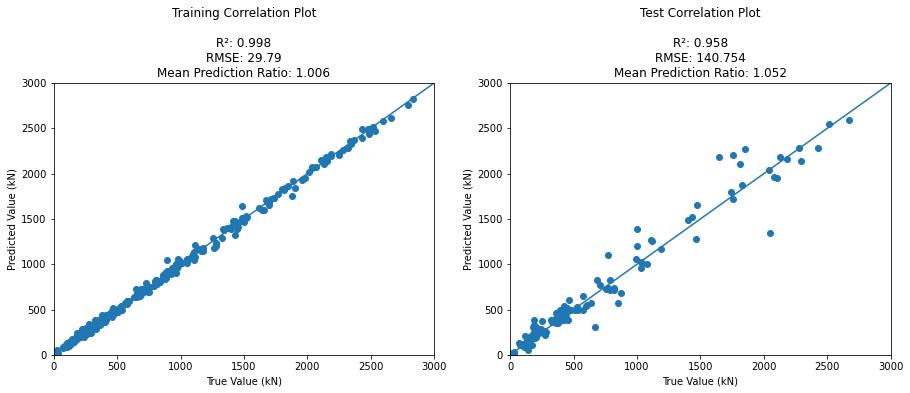

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

lgbm = LGBMRegressor()

lgbm_params = {'n_estimators': [50, 30000, 150, 200],
               'subsample': [0.1, 0.3, 0.5, 0.7],
               'min_child_samples': [3, 5, 8],
               'max_depth': [3, 6, 9],
               'num_leaves': [5, 10, 15, 20]}
        

gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv = 5, 
                     n_jobs = -1,
                     verbose = 2  
                     ).fit(X_train, y_train)

print("Best parameters:", gs_cv.best_params_)

lgbm_tuned = LGBMRegressor(**gs_cv.best_params_).fit(X_train, y_train)

y_pred_test = lgbm_tuned.predict(X_test)
y_pred_train = lgbm_tuned.predict(X_train)

acc_score_train = r2_score(y_pred_train, y_train)
acc_score_test = r2_score(y_pred_test, y_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

prediction_ratio_test = np.mean(y_pred_test / y_test)
prediction_ratio_train = np.mean(y_pred_train / y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(y_train, y_pred_train)
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Actual (kN)')
axs[0].set_ylabel("Prediction (kN)")
axs[0].set_title(f"Training Correlation Plot\n\nR\u00b2: {round(acc_score_train, 3)}\nRMSE: {round(rmse_train, 3)}\n" + r"$\hat{y}/y$: " + f"{round(prediction_ratio_train, 3)}")

axs[1].scatter(y_test, y_pred_test)
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].set_xlabel('Actual (kN)')
axs[1].set_ylabel("Prediction (kN)")
axs[1].set_title(f"Test Correlation Plot\n\nR\u00b2: {round(acc_score_test, 3)}\nRMSE: {round(rmse_test, 3)}\n" + r"$\hat{y}/y$: " + f"{round(prediction_ratio_test, 3)}")

plt.show()

In [ ]:
lgb = LGBMRegressor(n_estimators=200, num_leaves=10, max_depth=6, max_bin=100, min_child_samples=8, subsample=0.1)
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    lgb.fit(X_train, y_train)
    y_pred_train = lgb.predict(X_train)
    y_pred_test = lgb.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())
    feature_imp = pd.Series(lgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

Average Training R2 Score: 0.998, (0.0002)
Average Testing R2 Score: 0.9479, (0.0203)
Average Training RMSE: 30.2807, (1.8763)
Average Testing RMSE: 152.3031, (27.7311)
Average Training Mean Absolute Error: 21.5882, (1.1849)
Average Testing Mean Absolute Error: 93.3626, (12.0588)
Average Training Mean Absolute Percentage Error: 0.0591, (0.0037)
Average Testing Mean Absolute Percentage Error: 0.198, (0.0356)
Average Training Prediction Ratio: 1.005, (0.0021)
Average Testing Prediction Ratio: 1.0588, (0.0445)
Average Covariance of Training Prediction Ratios: 0.0109, (0.0029)
Average Covariance of Testing Prediction Ratios: 0.1289, (0.1316)
Random state that gives the best testing R2: 8316


In [ ]:
df_scores_lgbm = pd.DataFrame()
df_scores_lgbm["R\u00b2"] = r2_scores["testing"]
df_scores_lgbm["RMSE (kN)"] = rmse["testing"]
df_scores_lgbm["MAE (kN)"] = mae["testing"]
df_scores_lgbm["MAPE (%)"] = mape["testing"]
df_scores_lgbm["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_lgbm["COV"] = cov["testing"]

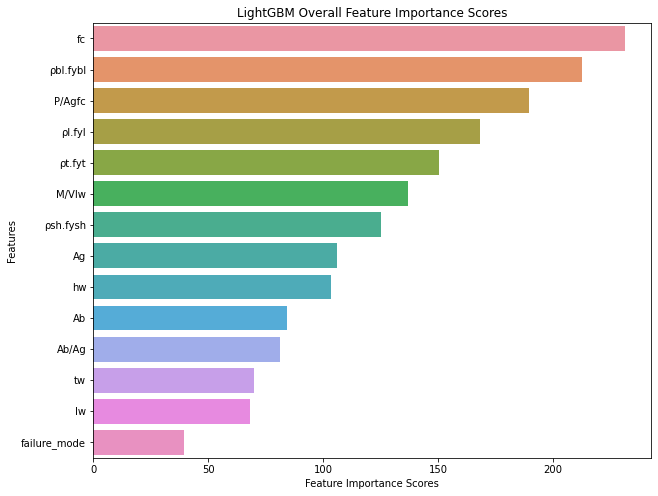

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(x=feature_imp_final, y=feature_imp_final.index)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("LightGBM Overall Feature Importance Scores")
plt.show()

## CatBoost

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'depth': 4, 'iterations': 600, 'loss_function': 'Poisson'}


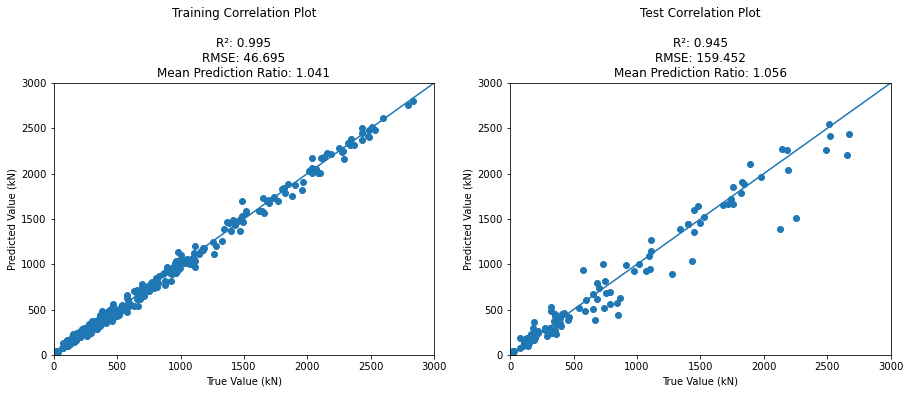

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

catb = CatBoostRegressor(silent=True)

catb_params = {'depth': [3, 4, 5, 6, 7],
               'iterations': [200, 400, 600],
			   "loss_function": ["Poisson", "RMSE"]}

gs_cv = GridSearchCV(catb,
                     catb_params,
                     cv = 5, 
                     n_jobs = -1, # -1 means using all processors
                     verbose = 2  # The higher, the more messages.
                     ).fit(X_train, y_train)
print("Best parameters:", gs_cv.best_params_)

catb_tuned = CatBoostRegressor(**gs_cv.best_params_, silent=True).fit(X_train, y_train)

y_pred_test = catb_tuned.predict(X_test)
y_pred_train = catb_tuned.predict(X_train)

acc_score_train = r2_score(y_pred_train, y_train)
acc_score_test = r2_score(y_pred_test, y_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

prediction_ratio_test = np.mean(y_pred_test / y_test)
prediction_ratio_train = np.mean(y_pred_train / y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(y_train, y_pred_train)
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Actual (kN)')
axs[0].set_ylabel("Prediction (kN)")
axs[0].set_title(f"Training Correlation Plot\n\nR\u00b2: {round(acc_score_train, 3)}\nRMSE: {round(rmse_train, 3)}\n" + r"$\hat{y}/y$: " + f"{round(prediction_ratio_train, 3)}")

axs[1].scatter(y_test, y_pred_test)
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].set_xlabel('Actual (kN)')
axs[1].set_ylabel("Prediction (kN)")
axs[1].set_title(f"Test Correlation Plot\n\nR\u00b2: {round(acc_score_test, 3)}\nRMSE: {round(rmse_test, 3)}\n" + r"$\hat{y}/y$: " + f"{round(prediction_ratio_test, 3)}")

plt.show()

In [ ]:
catb = CatBoostRegressor(iterations=600, depth=4, silent=True, loss_function="Poisson")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    catb.fit(X_train, y_train)
    y_pred_train = catb.predict(X_train)
    y_pred_test = catb.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())
    feature_imp = pd.Series(catb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing RMSE:", randomlist[np.argmax(rmse["testing"])])

feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

Average Training R2 Score: 0.9953, (0.0004)
Average Testing R2 Score: 0.9538, (0.0132)
Average Training RMSE: 47.0307, (2.0641)
Average Testing RMSE: 144.4799, (21.0531)
Average Training Mean Absolute Error: 35.8832, (1.4754)
Average Testing Mean Absolute Error: 91.8632, (10.6282)
Average Training Mean Absolute Percentage Error: 0.1036, (0.0041)
Average Testing Mean Absolute Percentage Error: 0.1842, (0.0203)
Average Training Prediction Ratio: 1.0437, (0.0029)
Average Testing Prediction Ratio: 1.0524, (0.031)
Average Covariance of Training Prediction Ratios: 0.0276, (0.0031)
Average Covariance of Testing Prediction Ratios: 0.0789, (0.0329)
Random state that gives the best testing RMSE: 4223


In [ ]:
df_scores_catb = pd.DataFrame()
df_scores_catb["R\u00b2"] = r2_scores["testing"]
df_scores_catb["RMSE (kN)"] = rmse["testing"]
df_scores_catb["MAE (kN)"] = mae["testing"]
df_scores_catb["MAPE (%)"] = mape["testing"]
df_scores_catb["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_catb["COV"] = cov["testing"]

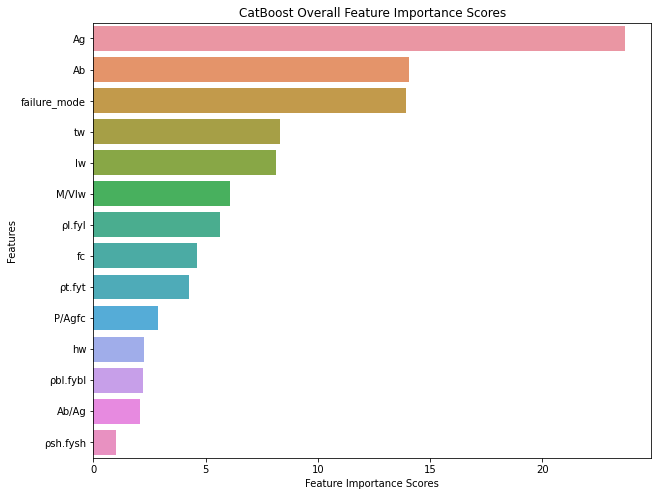

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(x=feature_imp_final, y=feature_imp_final.index)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("CatBoost Overall Feature Importance Scores")
plt.show()

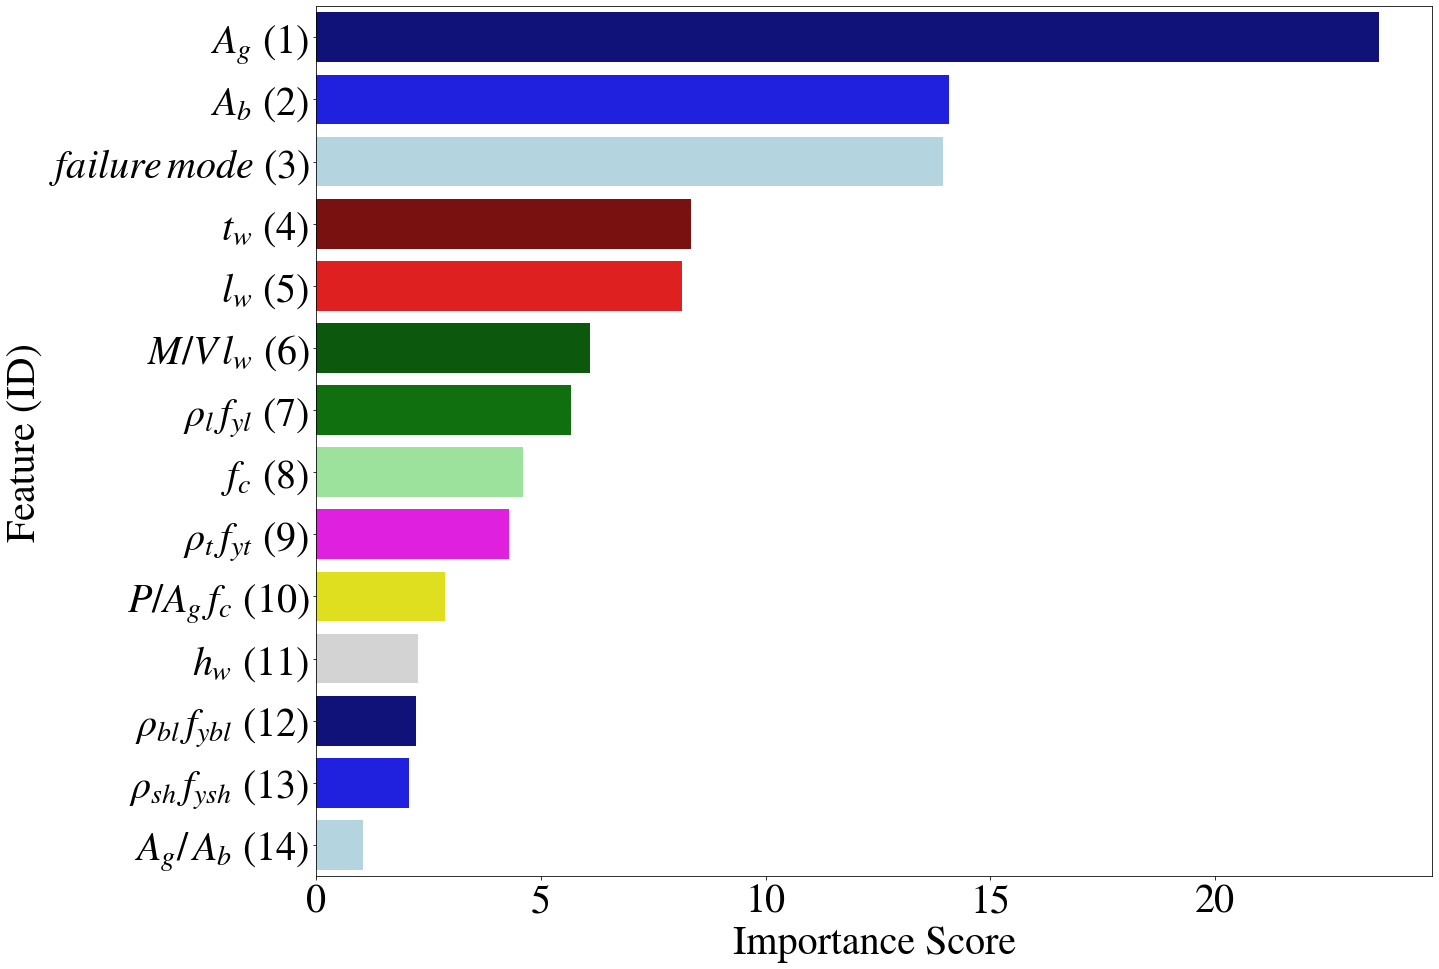

In [ ]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.rc('axes', labelsize=40)
plt.rc('axes', titlesize=40)
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)

colours = ["darkblue", "blue", "lightblue", "darkred", "red", "darkgreen", 
           "green", "lightgreen", "magenta", "yellow", "lightgray"]
plt.figure(figsize = (20, 16))
sns.barplot(x=feature_imp_final, y=[r"$A_g$ (1)", r"$A_b$ (2)", r"$failure\,mode$ (3)", r"$t_w$ (4)", r"$l_w$ (5)", 
                                    r"$M/V\,l_w$ (6)", r"$ρ_l\,f_{yl}$ (7)", r"$f_c$ (8)", r"$ρ_t\,f_{yt}$ (9)",  
                                    r"$P/A_{g}\,f_{c}$ (10)", r"$h_w$ (11)", r"$ρ_{bl}\,f_{ybl}$ (12)", 
                                    r"$ρ_{sh}\,f_{ysh}$ (13)", r"$A_g/\,A_b$ (14)",
                                    ], palette=colours)
plt.xlabel('Importance Score')
plt.ylabel('Feature (ID)')
plt.show()

## XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

xgb = XGBRegressor(verbosity=0)

xgb_params = {'n_estimators': [50, 30000, 150, 200],
               'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
               'min_child_samples': [3, 5, 8],
               'max_depth': [3, 5, 7, 9],
			   'subsample': [0.3, 0.5, 0.7]
               }
        

gs_cv = GridSearchCV(xgb,
                     xgb_params,
                     cv = 5, 
                     n_jobs = -1,
                     verbose = 2 
                     ).fit(X_train, y_train)

print("Best parameters:", gs_cv.best_params_)

xgb_tuned = XGBRegressor(**gs_cv.best_params_, verbosity=0).fit(X_train, y_train)

y_pred_test = xgb_tuned.predict(X_test)
y_pred_train = xgb_tuned.predict(X_train)

acc_score_train = r2_score(y_pred_train, y_train)
acc_score_test = r2_score(y_pred_test, y_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

prediction_ratio_test = np.mean(y_pred_test / y_test)
prediction_ratio_train = np.mean(y_pred_train / y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(y_train, y_pred_train)
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Actual (kN)')
axs[0].set_ylabel("Prediction (kN)")
axs[0].set_title(f"Training Correlation Plot\n\nR\u00b2: {round(acc_score_train, 3)}\nRMSE: {round(rmse_train, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_train, 3)}")

axs[1].scatter(y_test, y_pred_test)
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].set_xlabel('Actual (kN)')
axs[1].set_ylabel("Prediction (kN)")
axs[1].set_title(f"Test Correlation Plot\n\nR\u00b2: {round(acc_score_test, 3)}\nRMSE: {round(rmse_test, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_test, 3)}")

plt.show()

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


In [ ]:
xgb = XGBRegressor(verbosity=0, n_estimators=150, colsample_bytree=0.7, max_depth=3, subsample=0.5)
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())
    feature_imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9975, (0.0004)
Average Testing R2 Score: 0.9384, (0.0213)
Average Training RMSE: 34.3267, (2.599)
Average Testing RMSE: 166.0732, (26.3624)
Average Training Mean Absolute Error: 25.6731, (1.8394)
Average Testing Mean Absolute Error: 108.4077, (13.3446)
Average Training Mean Absolute Percentage Error: 0.0882, (0.0082)
Average Testing Mean Absolute Percentage Error: 0.2779, (0.0551)
Average Training Prediction Ratio: 1.0008, (0.007)
Average Testing Prediction Ratio: 1.052, (0.066)
Average Covariance of Training Prediction Ratios: 0.0363, (0.0123)
Average Covariance of Testing Prediction Ratios: 0.3138, (0.2748)
Random state that gives the best testing R2: 3002


In [ ]:
df_scores_xgb = pd.DataFrame()
df_scores_xgb["R\u00b2"] = r2_scores["testing"]
df_scores_xgb["RMSE (kN)"] = rmse["testing"]
df_scores_xgb["MAE (kN)"] = mae["testing"]
df_scores_xgb["MAPE (%)"] = mape["testing"]
df_scores_xgb["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_xgb["COV"] = cov["testing"]

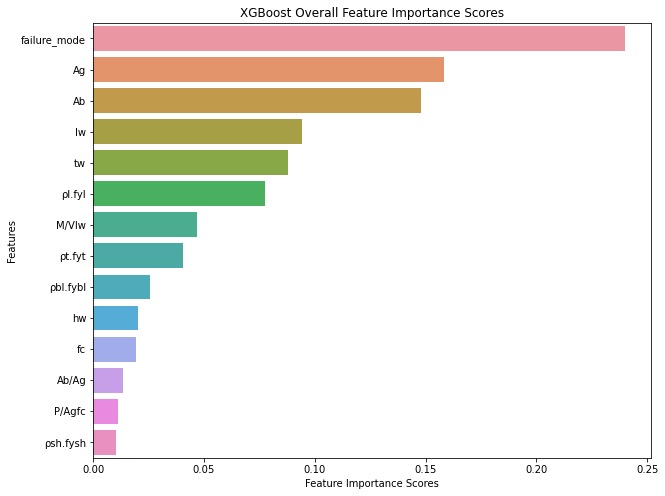

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(x=feature_imp_final, y=feature_imp_final.index)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("XGBoost Overall Feature Importance Scores")
plt.show()

## SVM

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters: {'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


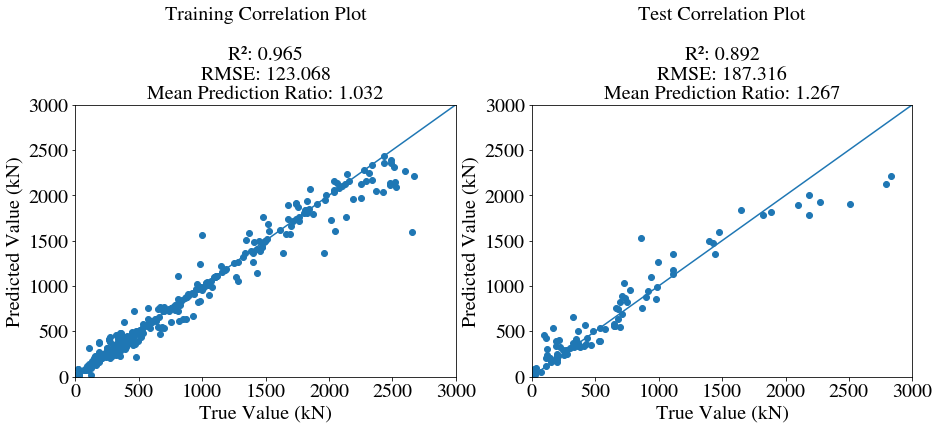

In [ ]:
svm = SVR()

svm_params = {
    'C': [0.01, 0.1, 1, 5, 10, 50, 30000, 300000],
    "kernel":['linear','poly','rbf','sigmoid'],
    "gamma": ["auto", "scale"],
    "degree": [2, 3, 4, 5]
}

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

gs_cv = GridSearchCV(svm,
                     svm_params,
                     cv = 5, 
                     n_jobs = -1, # -1 means using all processors
                     verbose = 2  # The higher, the more messages.
                     ).fit(X_train, y_train)

print("Best parameters:", gs_cv.best_params_)

svm_tuned = SVR(**gs_cv.best_params_).fit(X_train, y_train)

y_pred_test = svm_tuned.predict(X_test)
y_pred_train = svm_tuned.predict(X_train)

acc_score_train = r2_score(y_pred_train, y_train)
acc_score_test = r2_score(y_pred_test, y_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

prediction_ratio_test = np.mean(y_pred_test / y_test)
prediction_ratio_train = np.mean(y_pred_train / y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(y_train, y_pred_train)
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Actual (kN)')
axs[0].set_ylabel("Prediction (kN)")
axs[0].set_title(f"Training Correlation Plot\n\nR\u00b2: {round(acc_score_train, 3)}\nRMSE: {round(rmse_train, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_train, 3)}")

axs[1].scatter(y_test, y_pred_test)
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].set_xlabel('Actual (kN)')
axs[1].set_ylabel("Prediction (kN)")
axs[1].set_title(f"Test Correlation Plot\n\nR\u00b2: {round(acc_score_test, 3)}\nRMSE: {round(rmse_test, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_test, 3)}")

plt.show()

In [ ]:
svm = SVR(C=1000, gamma="scale", kernel="rbf")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    svm.fit(X_train, y_train)
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9706, (0.0026)
Average Testing R2 Score: 0.9269, (0.0177)
Average Training RMSE: 117.5693, (5.7457)
Average Testing RMSE: 182.626, (25.2398)
Average Training Mean Absolute Error: 55.4846, (2.6485)
Average Testing Mean Absolute Error: 112.5779, (13.8801)
Average Training Mean Absolute Percentage Error: 0.0976, (0.0073)
Average Testing Mean Absolute Percentage Error: 0.2599, (0.0543)
Average Training Prediction Ratio: 1.0168, (0.0091)
Average Testing Prediction Ratio: 1.0952, (0.0636)
Average Covariance of Training Prediction Ratios: 0.0462, (0.0218)
Average Covariance of Testing Prediction Ratios: 0.3074, (0.2063)
Random state that gives the best testing R2: 961


In [ ]:
df_scores_svm = pd.DataFrame()
df_scores_svm["R\u00b2"] = r2_scores["testing"]
df_scores_svm["RMSE (kN)"] = rmse["testing"]
df_scores_svm["MAE (kN)"] = mae["testing"]
df_scores_svm["MAPE (%)"] = mape["testing"]
df_scores_svm["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_svm["COV"] = cov["testing"]

## MLP

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (10, 20, 10), 'solver': 'lbfgs'}


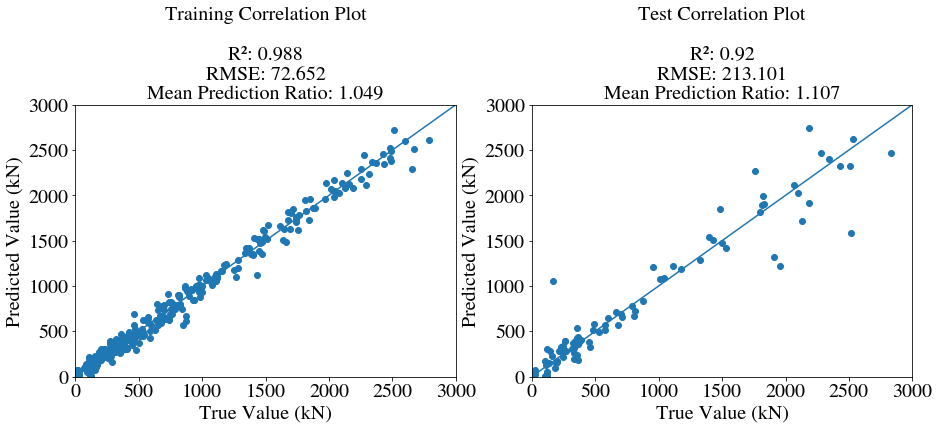

In [ ]:
mlp = MLPRegressor()

mlp_params = {"alpha": [1, 0.1, 0.01, 0.001], # regularization parameter
              "hidden_layer_sizes": [(5, 5),
                                     (10, 3000), 
                                     (10, 20, 3000),
                                     (15, 30, 15)],
              "solver" : ["lbfgs","adam","sgd"], 
               # lbfgs: quasi-Newton method
               # sgd: stochastic gradient descent
               # adam: stochastic gradient-based optimizer 
              "activation": ["tanh","logistic", "relu"]}


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
gs_cv = GridSearchCV(mlp,
                     mlp_params,
                     cv = 5, 
                     n_jobs = -1,
                     verbose = 2 
                     ).fit(X_train, y_train)

print("Best parameters:", gs_cv.best_params_)

mlp_tuned = MLPRegressor(**gs_cv.best_params_, ).fit(X_train, y_train)

y_pred_test = mlp_tuned.predict(X_test)
y_pred_train = mlp_tuned.predict(X_train)

acc_score_train = r2_score(y_pred_train, y_train)
acc_score_test = r2_score(y_pred_test, y_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

prediction_ratio_test = np.mean(y_pred_test / y_test)
prediction_ratio_train = np.mean(y_pred_train / y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(y_train, y_pred_train)
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Actual (kN)')
axs[0].set_ylabel("Prediction (kN)")
axs[0].set_title(f"Training Correlation Plot\n\nR\u00b2: {round(acc_score_train, 3)}\nRMSE: {round(rmse_train, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_train, 3)}")

axs[1].scatter(y_test, y_pred_test)
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].set_xlabel('Actual (kN)')
axs[1].set_ylabel("Prediction (kN)")
axs[1].set_title(f"Test Correlation Plot\n\nR\u00b2: {round(acc_score_test, 3)}\nRMSE: {round(rmse_test, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_test, 3)}")

plt.show()

In [ ]:
mlp = MLPRegressor(activation="relu", alpha=0.1, hidden_layer_sizes=(10, 20, 10), solver="lbfgs")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    mlp.fit(X_train, y_train)
    y_pred_train = mlp.predict(X_train)
    y_pred_test = mlp.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9857, (0.0036)
Average Testing R2 Score: 0.9163, (0.0431)
Average Training RMSE: 81.415, (10.6154)
Average Testing RMSE: 192.4169, (39.981)
Average Training Mean Absolute Error: 58.1201, (7.2424)
Average Testing Mean Absolute Error: 119.329, (15.104)
Average Training Mean Absolute Percentage Error: 0.1799, (0.0351)
Average Testing Mean Absolute Percentage Error: 0.3073, (0.0742)
Average Training Prediction Ratio: 1.0622, (0.0352)
Average Testing Prediction Ratio: 1.1274, (0.0812)
Average Covariance of Training Prediction Ratios: 0.1457, (0.1094)
Average Covariance of Testing Prediction Ratios: 0.4746, (0.7056)
Random state that gives the best testing R2: 8316


In [ ]:
df_scores_mlp = pd.DataFrame()
df_scores_mlp["R\u00b2"] = r2_scores["testing"]
df_scores_mlp["RMSE (kN)"] = rmse["testing"]
df_scores_mlp["MAE (kN)"] = mae["testing"]
df_scores_mlp["MAPE (%)"] = mape["testing"]
df_scores_mlp["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_mlp["COV"] = cov["testing"]

## Random Forests

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'max_depth': 10, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 150}


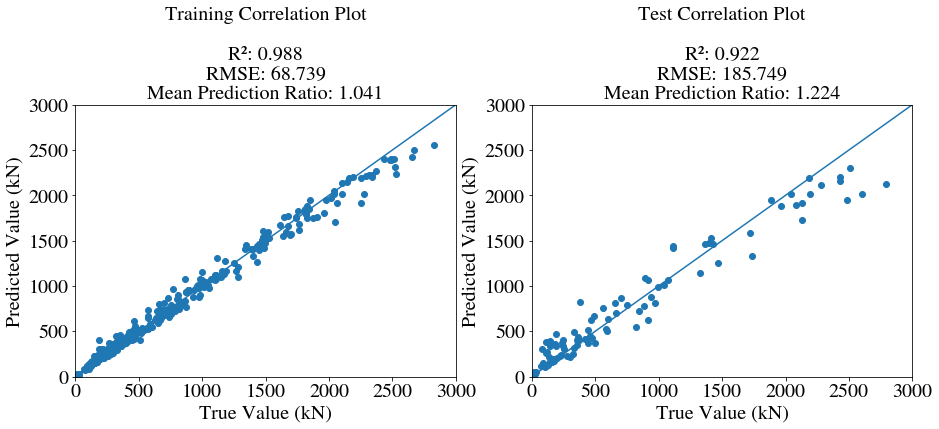

In [ ]:
rf = RandomForestRegressor()

rf_params = {"max_depth": [3, 6, 8, 10], 
            "max_features": [2, 5, 8], # The number of features to consider when looking for the best split
            "n_estimators": [50, 30000, 150, 200],
            "min_samples_split": [2, 5, 8, 10]}  # The minimum number of samples required to split an internal node

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gs_cv = GridSearchCV(rf,
                     rf_params,
                     cv = 5, 
                     n_jobs = -1,
                     verbose = 2  
                     ).fit(X_train, y_train)
print("Best parameters:", gs_cv.best_params_)

rf_tuned = RandomForestRegressor(**gs_cv.best_params_).fit(X_train, y_train)

y_pred_test = rf_tuned.predict(X_test)
y_pred_train = rf_tuned.predict(X_train)

acc_score_train = r2_score(y_pred_train, y_train)
acc_score_test = r2_score(y_pred_test, y_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

prediction_ratio_test = np.mean(y_pred_test / y_test)
prediction_ratio_train = np.mean(y_pred_train / y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(y_train, y_pred_train)
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Actual (kN)')
axs[0].set_ylabel("Prediction (kN)")
axs[0].set_title(f"Training Correlation Plot\n\nR\u00b2: {round(acc_score_train, 3)}\nRMSE: {round(rmse_train, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_train, 3)}")

axs[1].scatter(y_test, y_pred_test)
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].set_xlabel('Actual (kN)')
axs[1].set_ylabel("Prediction (kN)")
axs[1].set_title(f"Test Correlation Plot\n\nR\u00b2: {round(acc_score_test, 3)}\nRMSE: {round(rmse_test, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_test, 3)}")

plt.show()

In [ ]:
rf = RandomForestRegressor(max_depth=10, max_features=8, min_samples_split=2, n_estimators=150)
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())
    feature_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9902, (0.0008)
Average Testing R2 Score: 0.9347, (0.0177)
Average Training RMSE: 67.7452, (2.3786)
Average Testing RMSE: 172.0746, (23.8376)
Average Training Mean Absolute Error: 44.6376, (1.2931)
Average Testing Mean Absolute Error: 110.1009, (13.177)
Average Training Mean Absolute Percentage Error: 0.0935, (0.0035)
Average Testing Mean Absolute Percentage Error: 0.2232, (0.0361)
Average Training Prediction Ratio: 1.0492, (0.0034)
Average Testing Prediction Ratio: 1.1198, (0.0413)
Average Covariance of Training Prediction Ratios: 0.0231, (0.0029)
Average Covariance of Testing Prediction Ratios: 0.1377, (0.0716)
Random state that gives the best testing R2: 8892


In [ ]:
df_scores_rf = pd.DataFrame()
df_scores_rf["R\u00b2"] = r2_scores["testing"]
df_scores_rf["RMSE (kN)"] = rmse["testing"]
df_scores_rf["MAE (kN)"] = mae["testing"]
df_scores_rf["MAPE (%)"] = mape["testing"]
df_scores_rf["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_rf["COV"] = cov["testing"]

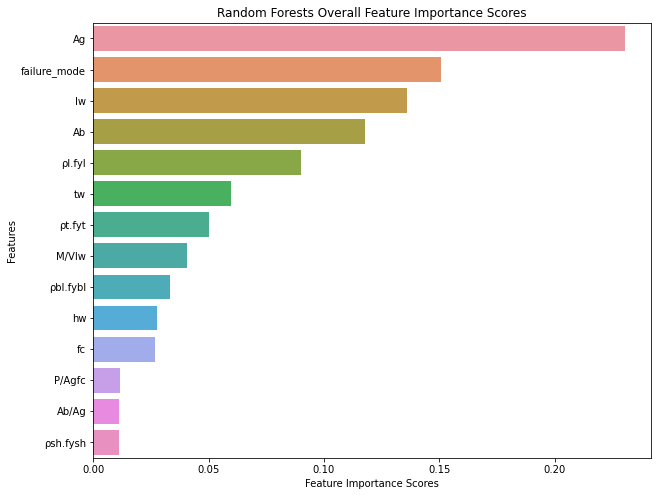

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(x=feature_imp_final, y=feature_imp_final.index)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("Random Forests Overall Feature Importance Scores")
plt.show()

## Linear Regression

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best parameters: {'alpha': 0.1, 'fit_intercept': True, 'normalize': True, 'solver': 'sparse_cg'}


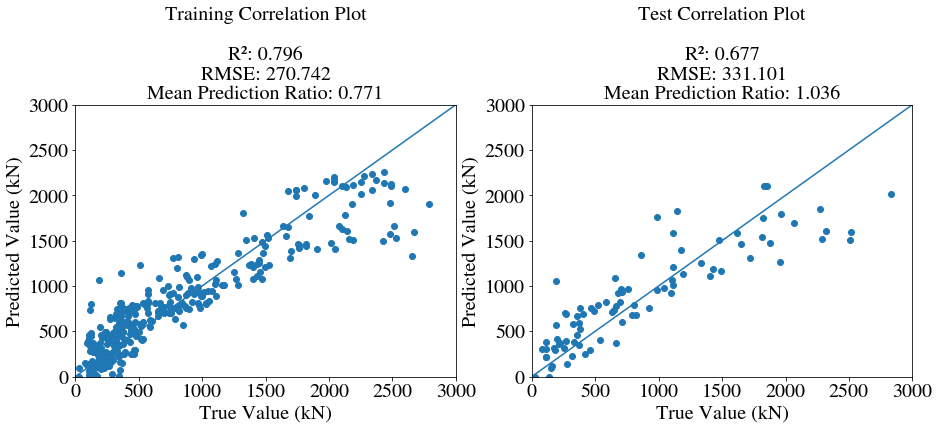

In [ ]:
lr = Ridge()

lr_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
            'fit_intercept': [True, False],
            'normalize': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            }

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

gs_cv = GridSearchCV(lr,
                     lr_params,
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2 
                     ).fit(X_train, y_train)
print("Best parameters:", gs_cv.best_params_)

lr_tuned = Ridge(**gs_cv.best_params_).fit(X_train, y_train)

y_pred_test = lr_tuned.predict(X_test)
y_pred_train = lr_tuned.predict(X_train)

acc_score_train = r2_score(y_pred_train, y_train)
acc_score_test = r2_score(y_pred_test, y_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

prediction_ratio_test = np.mean(y_pred_test / y_test)
prediction_ratio_train = np.mean(y_pred_train / y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(y_train, y_pred_train)
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Actual (kN)')
axs[0].set_ylabel("Prediction (kN)")
axs[0].set_title(f"Training Correlation Plot\n\nR\u00b2: {round(acc_score_train, 3)}\nRMSE: {round(rmse_train, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_train, 3)}")

axs[1].scatter(y_test, y_pred_test)
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].set_xlabel('Actual (kN)')
axs[1].set_ylabel("Prediction (kN)")
axs[1].set_title(f"Test Correlation Plot\n\nR\u00b2: {round(acc_score_test, 3)}\nRMSE: {round(rmse_test, 3)}\n" + r"$\hat{y}/y$: " + f" {round(prediction_ratio_test, 3)}")

plt.show()

In [ ]:
lr = Ridge(alpha=0.1, fit_intercept=True, normalize=True, solver="sparse_cg")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.8319, (0.0071)
Average Testing R2 Score: 0.8122, (0.0319)
Average Training RMSE: 281.1514, (6.0155)
Average Testing RMSE: 293.2425, (25.2457)
Average Training Mean Absolute Error: 207.3788, (4.4611)
Average Testing Mean Absolute Error: 215.6307, (16.0165)
Average Training Mean Absolute Percentage Error: 0.8962, (0.0427)
Average Testing Mean Absolute Percentage Error: 0.9141, (0.2127)
Average Training Prediction Ratio: 0.7907, (0.0412)
Average Testing Prediction Ratio: 0.8151, (0.2502)
Average Covariance of Training Prediction Ratios: 6.2831, (0.919)
Average Covariance of Testing Prediction Ratios: 6.3675, (4.6444)
Random state that gives the best testing R2: 1622


In [ ]:
df_scores_lr = pd.DataFrame()
df_scores_lr["R\u00b2"] = r2_scores["testing"]
df_scores_lr["RMSE (kN)"] = rmse["testing"]
df_scores_lr["MAE (kN)"] = mae["testing"]
df_scores_lr["MAPE (%)"] = mape["testing"]
df_scores_lr["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_lr["COV"] = cov["testing"]

## Overall Evaluation

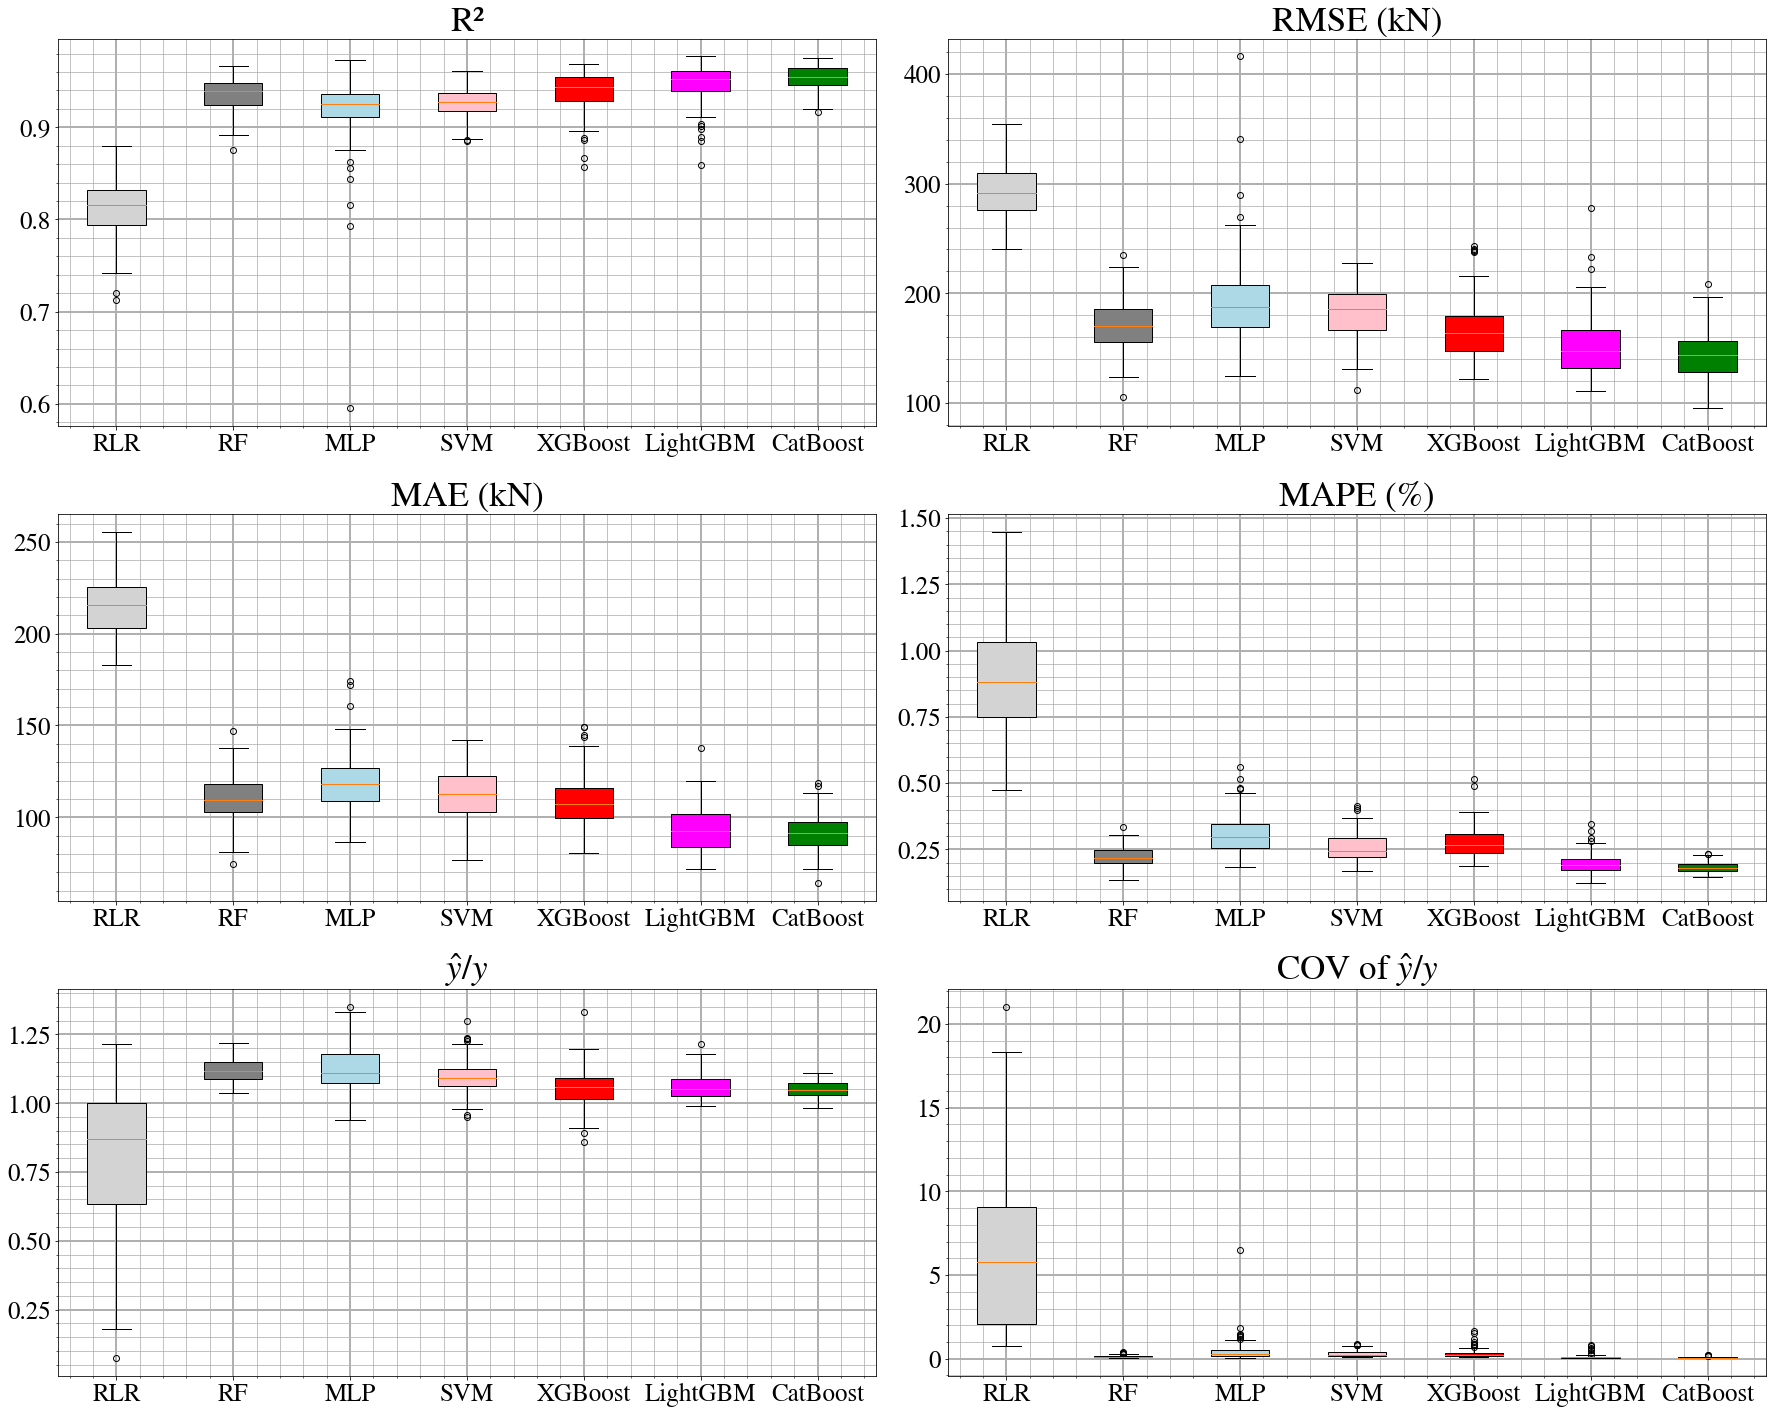

In [ ]:
r2_dict = {'RLR': df_scores_lr["R\u00b2"].values, 'RF': df_scores_rf["R\u00b2"].values,
           'MLP': df_scores_mlp["R\u00b2"].values, 'SVM': df_scores_svm["R\u00b2"].values,
           'XGBoost': df_scores_xgb["R\u00b2"].values, 'LightGBM': df_scores_lgbm["R\u00b2"].values,
           'CatBoost': df_scores_catb["R\u00b2"].values,
           }

rmse_dict = {'RLR': df_scores_lr["RMSE (kN)"].values, 'RF': df_scores_rf["RMSE (kN)"].values,
           'MLP': df_scores_mlp["RMSE (kN)"].values, 'SVM': df_scores_svm["RMSE (kN)"].values,
           'XGBoost': df_scores_xgb["RMSE (kN)"].values, 'LightGBM': df_scores_lgbm["RMSE (kN)"].values,
           'CatBoost': df_scores_catb["RMSE (kN)"].values,
           }

mae_dict = {'RLR': df_scores_lr["MAE (kN)"].values, 'RF': df_scores_rf["MAE (kN)"].values,
           'MLP': df_scores_mlp["MAE (kN)"].values, 'SVM': df_scores_svm["MAE (kN)"].values,
           'XGBoost': df_scores_xgb["MAE (kN)"].values, 'LightGBM': df_scores_lgbm["MAE (kN)"].values,
           'CatBoost': df_scores_catb["MAE (kN)"].values,
           }

mape_dict = {'RLR': df_scores_lr["MAPE (%)"].values, 'RF': df_scores_rf["MAPE (%)"].values,
           'MLP': df_scores_mlp["MAPE (%)"].values, 'SVM': df_scores_svm["MAPE (%)"].values,
           'XGBoost': df_scores_xgb["MAPE (%)"].values, 'LightGBM': df_scores_lgbm["MAPE (%)"].values,
           'CatBoost': df_scores_catb["MAPE (%)"].values,
           }

ratio_dict = {'RLR': df_scores_lr["Vpred / Vtrue"].values, 'RF': df_scores_rf["Vpred / Vtrue"].values,
           'MLP': df_scores_mlp["Vpred / Vtrue"].values, 'SVM': df_scores_svm["Vpred / Vtrue"].values,
           'XGBoost': df_scores_xgb["Vpred / Vtrue"].values, 'LightGBM': df_scores_lgbm["Vpred / Vtrue"].values,
           'CatBoost': df_scores_catb["Vpred / Vtrue"].values,
           }

cov_dict = {'RLR': df_scores_lr["COV"].values, 'RF': df_scores_rf["COV"].values,
           'MLP': df_scores_mlp["COV"].values, 'SVM': df_scores_svm["COV"].values,
           'XGBoost': df_scores_xgb["COV"].values, 'LightGBM': df_scores_lgbm["COV"].values,
           'CatBoost': df_scores_catb["COV"].values,
           }

plt.rc('axes', labelsize=35)
plt.rc('axes', titlesize=35)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

colours = ["lightgray", "gray", "lightblue", "pink", "red", "magenta", "green"]

fig, axs = plt.subplots(3, 2, figsize=(25, 20))

axs[0, 0].set_title("R\u00b2")
bplot1 = axs[0, 0].boxplot(r2_dict.values(), patch_artist=True)
axs[0, 0].set_xticklabels(r2_dict.keys())
axs[0, 0].grid(which="minor", linewidth=0.75)
axs[0, 0].grid(which="major", linewidth=2)
axs[0, 0].minorticks_on()
for patch, color in zip(bplot1['boxes'], colours):
    patch.set_facecolor(color)

axs[0, 1].set_title("RMSE (kN)")
bplot2 = axs[0, 1].boxplot(rmse_dict.values(), patch_artist=True)
axs[0, 1].set_xticklabels(rmse_dict.keys())
axs[0, 1].grid(which="minor", linewidth=0.75)
axs[0, 1].grid(which="major", linewidth=2)
axs[0, 1].minorticks_on()
for patch, color in zip(bplot2['boxes'], colours):
    patch.set_facecolor(color)

axs[1, 0].set_title("MAE (kN)")
bplot3 = axs[1, 0].boxplot(mae_dict.values(), patch_artist=True)
axs[1, 0].set_xticklabels(mae_dict.keys())
axs[1, 0].grid(which="minor", linewidth=0.75)
axs[1, 0].grid(which="major", linewidth=2)
axs[1, 0].minorticks_on()
for patch, color in zip(bplot3['boxes'], colours):
    patch.set_facecolor(color)


axs[1, 1].set_title("MAPE (%)")
bplot4 = axs[1, 1].boxplot(mape_dict.values(), patch_artist=True)
axs[1, 1].set_xticklabels(mape_dict.keys())
axs[1, 1].grid(which="minor", linewidth=0.75)
axs[1, 1].grid(which="major", linewidth=2)
axs[1, 1].minorticks_on()
for patch, color in zip(bplot4['boxes'], colours):
    patch.set_facecolor(color)

axs[2, 0].set_title(r"$\hat{y}/y$")
bplot5 = axs[2, 0].boxplot(ratio_dict.values(), patch_artist=True)
axs[2, 0].set_xticklabels(ratio_dict.keys())
axs[2, 0].grid(which="minor", linewidth=0.75)
axs[2, 0].grid(which="major", linewidth=2)
axs[2, 0].minorticks_on()
for patch, color in zip(bplot5['boxes'], colours):
    patch.set_facecolor(color)

axs[2, 1].set_title(r"COV of $\hat{y}/y$")
bplot6 = axs[2, 1].boxplot(cov_dict.values(), patch_artist=True)
axs[2, 1].set_xticklabels(cov_dict.keys())
axs[2, 1].grid(which="minor", linewidth=0.75)
axs[2, 1].grid(which="major", linewidth=2)
axs[2, 1].minorticks_on()
for patch, color in zip(bplot6['boxes'], colours):
    patch.set_facecolor(color)

plt.tight_layout(pad=2)
plt.show()

# Feature Selection for CatBoost Model

In [ ]:
acc_scores = {"r2": [0.9538], "rmse": [144.4799], "mae": [91.8632], "mape": [0.1842], "pratio": [1.0524], "cov": [0.0789]}
selected_features = []
Z = X.copy()

catb_sel = CatBoostRegressor(iterations=600, depth=4, silent=True, loss_function="Poisson")

for j in range(len(Z.columns)-1):

    Z.drop(feature_imp_final.index[-(j+1)], axis=1, inplace=True)
    selected_features.append(Z.columns.to_list())
    scores = {"r2": [], "rmse": [], "mae": [], "mape": [], "pratio": [], "cov": []}

    for i in randomlist:
        Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=i)
        catb_sel.fit(Z_train, y_train)
        y_pred_test = catb_sel.predict(Z_test)
        scores["r2"].append(r2_score(y_test, y_pred_test))
        scores["rmse"].append(mean_squared_error(y_test, y_pred_test, squared=False))
        scores["mae"].append(mean_absolute_error(y_test, y_pred_test))
        scores["mape"].append(mean_absolute_percentage_error(y_test, y_pred_test))
        scores["pratio"].append(np.mean(y_pred_test / y_test))
        scores["cov"].append(np.cov(y_pred_test / y_test).tolist())

    acc_scores["r2"].append(np.mean(scores['r2']))
    acc_scores["rmse"].append(np.mean(scores['rmse']))
    acc_scores["mae"].append(np.mean(scores['mae']))
    acc_scores["mape"].append(np.mean(scores['mape']))
    acc_scores["pratio"].append(np.mean(scores['pratio']))
    acc_scores["cov"].append(np.mean(scores['cov']))

acc_scores

{'r2': [0.9538,
  0.9526154101186068,
  0.9530326162623155,
  0.9478080852718946,
  0.9381428788599614,
  0.9400706033578229,
  0.9219107658948953,
  0.8995139038706043,
  0.9099403889191734,
  0.9082426934338802,
  0.8537939352554395,
  0.8527101433376371,
  0.8306603706821377,
  0.6952349560307581],
 'rmse': [144.4799,
  146.21170344994428,
  145.35722233416845,
  153.93546087329855,
  167.25376696213425,
  164.66739236123468,
  187.97262565939624,
  213.63839109861965,
  202.19845530152318,
  204.24223697500346,
  256.4609595574937,
  257.80526163944603,
  276.115515627181,
  371.41259855482275],
 'mae': [91.8632,
  91.84960577160084,
  91.15779873578342,
  100.74796879054871,
  109.19640311443379,
  109.32325022992003,
  122.65871018341329,
  140.45424279883434,
  134.22045487000796,
  136.86666564925858,
  163.3682539027711,
  167.59749881063536,
  179.49562777098942,
  243.19132685173193],
 'mape': [0.1842,
  0.18013950554664582,
  0.17774259689178543,
  0.20069527948535842,
  0.

# Interpretation of CatBoost Regression Model with 12 Features

In [11]:
X_new = X[['tw', 'lw', 'hw', 'M/Vlw', 'P/Agfc', 'fc', 'Ab', 'Ag', 'ρbl.fybl', 
'ρl.fyl', 'ρt.fyt', 'failure_mode']]
X_new.head()

,tw,lw,hw,M/Vlw,P/Agfc,fc,Ab,Ag,ρbl.fybl,ρl.fyl,ρt.fyt,failure_mode
0,150.0,1000,2200.0,2.20,0.00,30.5,30000.0,150000.0,5.652500,2.847500,3.740000,3.0
1,150.0,1400,2000.0,1.43,0.01,46.8,0.0,210000.0,0.000000,4.410368,2.021229,3.0
2,150.0,1400,2000.0,1.43,0.01,46.6,0.0,210000.0,0.000000,7.725619,2.021229,1.0
3,127.0,1625,12000.0,7.38,0.10,49.0,77140.0,309093.0,2.956163,1.219476,1.177428,3.0
4,100.0,700,1600.0,2.50,0.15,27.4,10000.0,70000.0,14.732880,2.673600,2.655481,2.0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=8316)
catb_tuned = CatBoostRegressor(iterations=1500, depth=3, silent=True, loss_function="Poisson").fit(X_train, y_train)

## Interpretation with LIME

In [13]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_new.columns,
    verbose=True,
    mode='regression'
)

# application of lime:
lime_r2_scores = []
for i in range(len(y_test)):
    exp = explainer.explain_instance(data_row=X_test.iloc[i], num_features=12, 
                                    predict_fn=catb_tuned.predict, )
    lime_r2_scores.append(exp.score)

Intercept 485.2274773001285
Prediction_local [500.23914125]
Right: 730.3954343857796
Intercept 227.7959692771687
Prediction_local [1230.57547103]
Right: 1805.8164277383453
Intercept 425.6147576542876
Prediction_local [727.01373346]
Right: 722.8443247706658
Intercept 299.74769291471915
Prediction_local [1009.05414648]
Right: 1907.5903350220049
Intercept 489.94703501150906
Prediction_local [423.13216487]
Right: 294.67958194027057
Intercept 733.2488202993056
Prediction_local [-141.8658279]
Right: 26.261084999251267
Intercept 667.6031933734316
Prediction_local [0.47282637]
Right: 189.12525156720736
Intercept 438.822398063029
Prediction_local [681.30667671]
Right: 405.0229051547443
Intercept 682.5673953447467
Prediction_local [77.0932881]
Right: 117.47529384081739
Intercept 700.4562000765786
Prediction_local [-68.45796049]
Right: 24.38765860098599
Intercept 517.1349452641812
Prediction_local [487.93589477]
Right: 429.0199032703807
Intercept 709.142105229619
Prediction_local [-75.55527331]
R

In [14]:
print(np.mean(lime_r2_scores))
print(np.std(lime_r2_scores))

0.301279091526053
0.10254529204224587


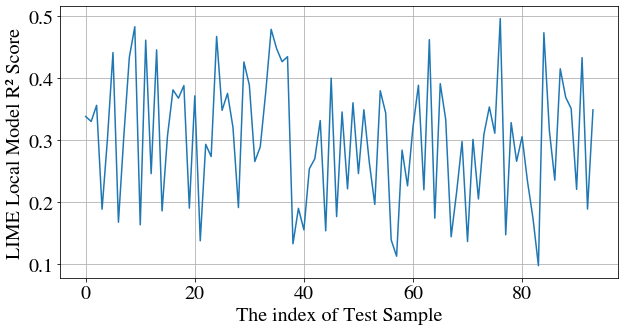

In [15]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20)

y_r2 = np.array(lime_r2_scores)
x_r2 = np.arange(len(lime_r2_scores))
plt.figure(figsize=(10,5))
plt.plot(x_r2, y_r2)
plt.xlabel("The index of Test Sample")
plt.ylabel("LIME Local Model R\u00b2 Score")
plt.grid('major')
plt.show()

## Interpretation with SHAP

In [16]:
X_new.columns

Index(['tw', 'lw', 'hw', 'M/Vlw', 'P/Agfc', 'fc', 'Ab', 'Ag', 'ρbl.fybl',
       'ρl.fyl', 'ρt.fyt', 'failure_mode'],
      dtype='object')

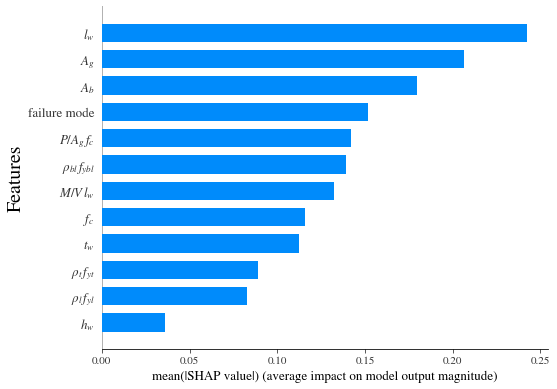

In [17]:
names=[r"$t_w$", r"$l_w$", r"$h_w$", r"$M/V\,l_w$", r"$P/A_{g}\,f_{c}$", r"$f_c$",
   r"$A_{b}$", r"$A_{g}$", r"$\rho_{bl}\,f_{ybl}$", r"$\rho_l\,f_{yl}$", 
   r"$\rho_t\,f_{yt}$", "failure mode"]

explainer = shap.TreeExplainer(catb_tuned)
shap_values = explainer.shap_values(X_new)
plt.ylabel("Features")
shap.summary_plot(shap_values, X_new, names, plot_type="bar", show=False)

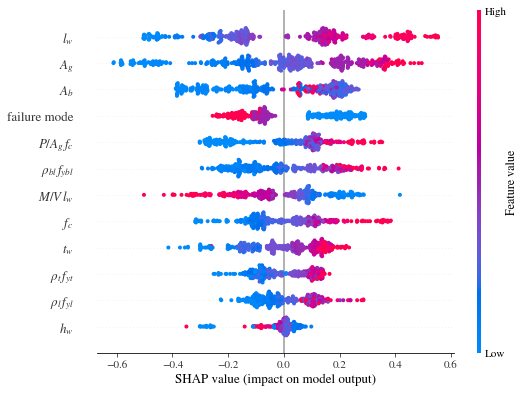

In [18]:
# Effects of features on shear strength estimation
shap.summary_plot(shap_values, X_new, names, show=False)

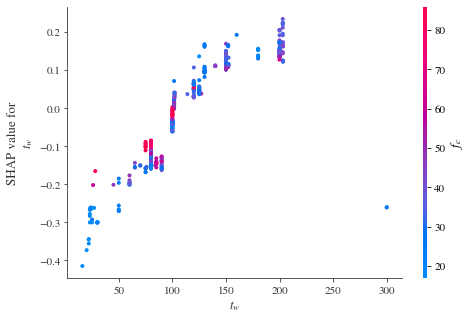

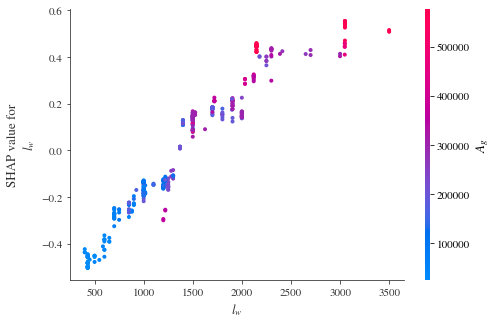

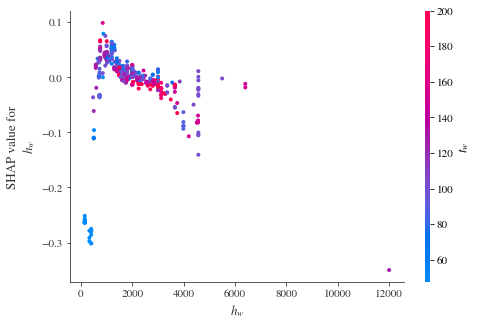

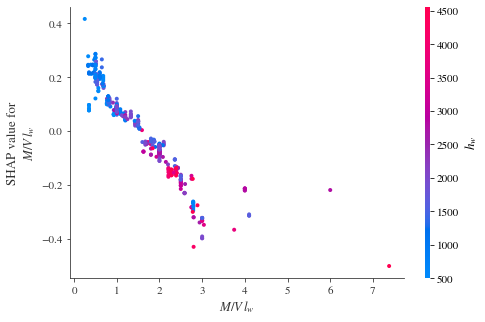

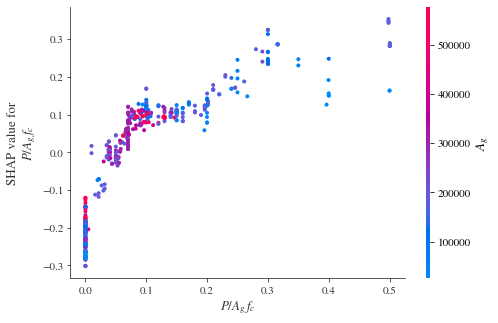

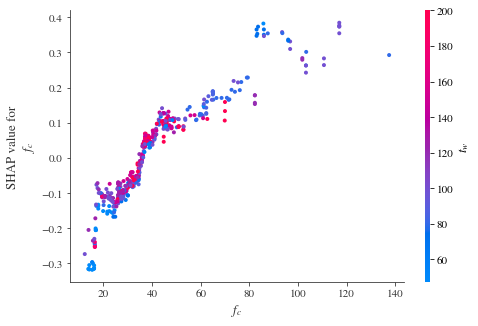

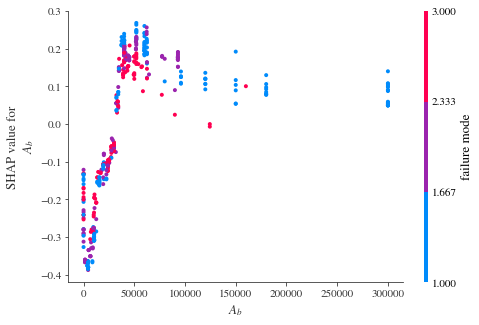

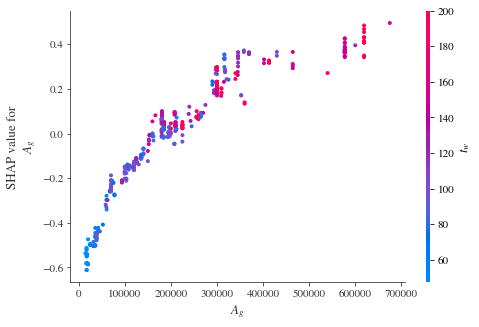

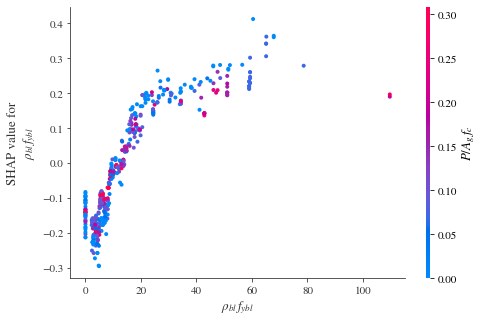

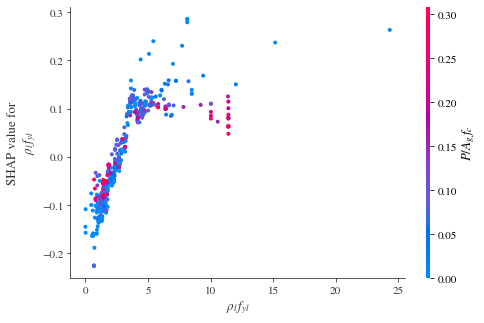

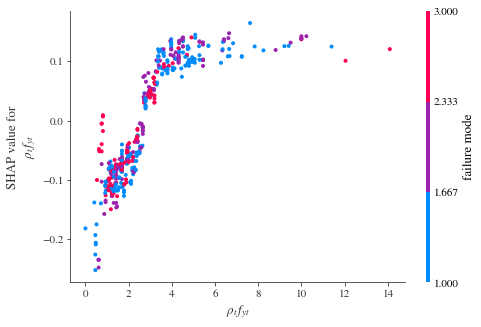

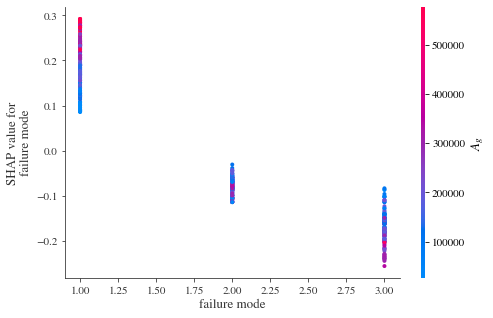

In [19]:
# Dependence plots of the features
for i in range(len(X_new.columns)):
    shap.dependence_plot(ind=i, shap_values=shap_values, features=X_new, feature_names=names)